# Parameter tracking in a Fitzhugh-Nagumo system with an unscented Kalman filter 

Code adapted from Matlab by FPB 

### Original credit 

% Unscented Kalman Filter (UKF) applied to FitzHugh-Nagumo neuron dynamics.

% Voltage observed, currents and inputs estimated.

% FitzHughNagumo() is the main program and calls the other programs.

% A detailed description is provided in
 H.U. Voss, J. Timmer & J. Kurths, Nonlinear dynamical system identification from uncertain and indirect measurements, Int. J. Bifurcation and Chaos 14, 1905-1933 (2004).

I will be happy to email this paper on request. It contains a tutorial about the estimation of hidden states and unscented Kalman filtering.
%
 For commercial use and questions, please contact me.
%
++++++++++++++++++++++++++++++++++++++++++++++

 Henning U. Voss, Ph.D.
 
 Associate Professor of Physics in Radiology
 
 Citigroup Biomedical Imaging Center

 Weill Medical College of Cornell University
 
 516 E 72nd Street
 
 New York, NY 10021
 
 Tel. 001-212 746-5216, Fax. 001-212 746-6681
 
 Email: hev2006@med.cornell.edu
++++++++++++++++++++++++++++++++++++++++++++++

Written 15. 7. 2002

Updated 30. 8. 2016 (R2015b):

 - Change of random number generator to ensure future compatibility
 
 - Eliminiation of yellow warnings


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm, block_diag

# Unscented Kalman Filter (UKF) applied to FitzHugh-Nagumo neuron dynamics.

### Basic definitions

Here we define the basic parameters of the simulation. We give the parameters of the Fitzhugh Nagumo system we want to simulate `a, b, c` and the values that we use for our Kalman model `a_mod, b_mod, c_mod`. Importantly, in the starting "easy" case, these two sets are taken to be identical, but in general we have no access to the true parameters (nor will the "real" system be "exactly" FN) 

In [14]:
# Dimensions: dq for param. vector, dx augmented state, dy observation
dq = 1
dx = dq + 2
dy = 1

ll = 800  # number of data samples
dT = 0.2  # sampling time step (global variable)

a, b, c = 0.7, 0.8, 3. # these are the parameter value for the "true" target system

#a_mod, b_mod, c_mod = a, b, c # these are the parameter values in our model. In this case identical
                              # but it doesn't have to be (for example, we may not *know* the true 
                              # values
a_mod, b_mod, c_mod = 0.3, 0.8, 3 # uncomment and change at will to experiment 

Q = 0.015  # process noise covariance matrix
#Q = 0.0001
R0 = 0.2 # observation noise standard deviation, in units of the standard deviations of the "signal"

This is the function we use to generate the true system, that we will then try to estimate. 

In [3]:
# Function for modeling data, not for UKF execution
def FitzHughNagumo_int(x, z):
    #a, b, c = 0.7, 0.8, 3.0
    return np.array([c * (x[1] + x[0] - x[0]**3 / 3 + z), -(x[0] - a + b * x[1]) / c])

Here is the observation function. We assume that we are observing the membrane potential (or a noisy version thereof)

In [4]:
# Observation function G(x)
def FitzHughNagumo_obsfct(x):
    return x[1, :]

In [5]:
# Model function F(x)
def fc(x, p):
    a, b, c = a_mod, b_mod, c_mod
    #p = p.ravel()
    x = np.atleast_2d(x)
    #return np.array([c * (x[1,:] + x[0,:] - x[0,:]**3 / 3 + p), -(x[0,:] - a + b * x[1,:]) / c])
    rr = [np.atleast_2d(c * (x[1,:] + x[0,:] - x[0,:]**3 / 3 + p)), np.atleast_2d(-(x[0,:] - a + b * x[1,:]) / c)]
    #print(rr)
    return(np.vstack(rr))

Here we generate the data for the real system. `z` contains the external input (typically called `I` because it is a current. Following the paper, we will use a periodic function ("piecewise sine wave"). 
Because we are trying to estimate the external input as well, we augment out state vector so that it contains $(x(t), y(t), I(t))$ (following book notation, here `[z,x0[0],x0[1]]` )

In [6]:
# Simulating data
x0 = np.zeros((2, ll))
x0[:, 0] = [0, 0]  # true trajectory
dt = 0.1 * dT
nn = int(dT / dt)  # the integration time step is smaller than dT

# External input, estimated as parameter p later on
z = (np.arange(ll) / 250) * 2 * np.pi
z = -0.4 - 1.01 * np.abs(np.sin(z / 2))
#z = -.4 - 1.01 * np.abs(np.sin(z / 2))

# 4th order Runge-Kutta integrator for FitzHugh-Nagumo system with external input
for n in range(ll - 1):
    xx = x0[:, n]
    for i in range(nn):
        k1 = dt * FitzHughNagumo_int(xx, z[n])
        k2 = dt * FitzHughNagumo_int(xx + k1 / 2, z[n])
        k3 = dt * FitzHughNagumo_int(xx + k2 / 2, z[n])
        k4 = dt * FitzHughNagumo_int(xx + k3, z[n])
        xx = xx + k1 / 6 + k2 / 3 + k3 / 3 + k4 / 6
    x0[:, n + 1] = xx

x = np.vstack([z, x0])  # augmented state vector (notation a bit different to paper)

Text(0, 0.5, 'x (membrane potential)')

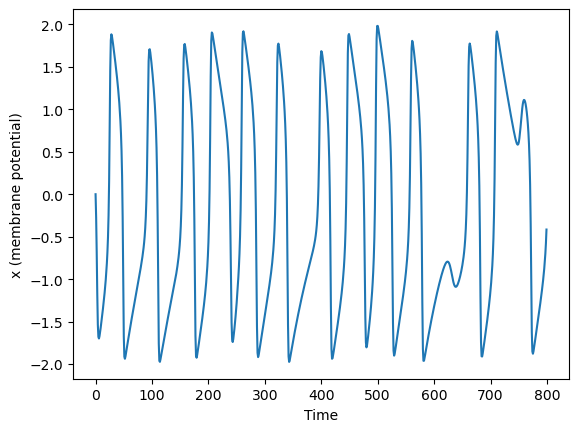

In [7]:
plt.figure()
plt.plot(x[1,:])
#plt.plot(xhat[1,1:6])
plt.xlabel('Time')
plt.ylabel('x (membrane potential)')

Here we generate our observations, as a noisy copy of the $x(t)$ variable

In [8]:
R = R0**2 * np.var(FitzHughNagumo_obsfct(x)) * np.eye(dy, dy)  # observation noise covariance matrix
np.random.seed(43211145)
y = FitzHughNagumo_obsfct(x) + np.dot(sqrtm(R), np.random.randn(dy, ll))  # noisy data





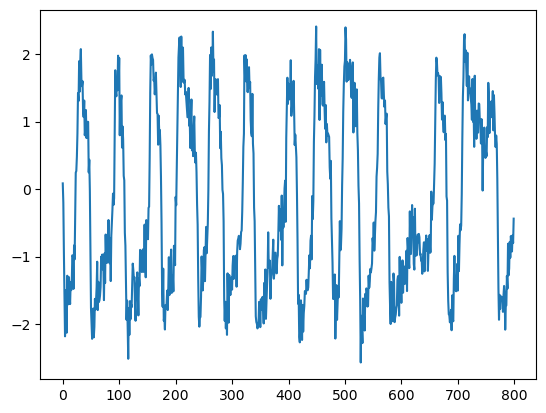

In [9]:
plt.plot(y.T)

This is the Kalman model $F(x)$. Remember that the state vector includes the parameters (first `dq` 
indices) and the dynamical variables (remaining ones). The function leaves the parameter estimate "as is" and integrates (4th order Runge-Kutta) the dynamical variables for the interval corresponding to the discrete time step of the Kalman Filter.

It is a generic function, that can be used for any sort of model. The model Fitzhugh-Nagumo equation is contained in the `fc` function, above. 

In [10]:
def FitzHughNagumo_fct(dq, x):
    # Model function F(x)

    dt = 0.02  # local integration step
    nn = int(np.fix(dT / dt))

    p = x[:dq, :]
    xnl = x[dq:, :]

    # 4th order Runge-Kutta integrator for FitzHugh-Nagumo system with parameters
    for i in range(nn):
        #print(p)
        k1 = dt * fc(xnl, p)
        k2 = dt * fc(xnl + k1 / 2, p)
        k3 = dt * fc(xnl + k2 / 2, p)
        k4 = dt * fc(xnl + k3, p)
        xnl = xnl + k1 / 6 + k2 / 3 + k3 / 3 + k4 / 6
    #print(x.shape)
    #print(xnl.shape)
    
    r = np.vstack([x[:dq, :], xnl])
    return r


This is the Unscented Kalman Filter implementation (again, generic)

In [11]:
# Unscented transformation. Not specific to FitzHugh-Nagumo model
def ut(xhat, Pxx, y, fct, obsfct, dq, dx, dy, R):

    N = 2 * dx
    
    xsigma = sqrtm(dx * Pxx).T  # Pxx = root * root', but Pxx = chol' * chol
    Xa = xhat[:, np.newaxis] + np.hstack([xsigma, -xsigma])
    X = fct(dq, Xa)

    xtilde = np.mean(X, axis=1)  # same as xtilde = np.sum(X, axis=1) / N

    Pxx = np.zeros((dx, dx))
    for i in range(N):
        Pxx += np.outer((X[:, i] - xtilde), (X[:, i] - xtilde)) / N

    Y = np.atleast_2d(obsfct(X))

    ytilde = np.mean(Y, axis=1)
    Pyy = R.copy()
    for i in range(N):
        Pyy += np.outer((Y[:, i] - ytilde), (Y[:, i] - ytilde)) / N

    Pxy = np.zeros((dx, dy))
    for i in range(N):
        Pxy += np.outer((X[:, i] - xtilde), (Y[:, i] - ytilde)) / N

    K = np.dot(Pxy, np.linalg.inv(Pyy))  # same as K = np.dot(Pxy, np.linalg.inv(Pyy))
    xhat = xtilde + np.dot(K, (y - ytilde))
    Pxx = Pxx - np.dot(K, Pxy.T)

    return xhat, Pxx, K

Here is the main loop for the estimation of the UKF

In [15]:
# Initial conditions
xhat = np.zeros((dx, ll))
xhat[:, 0] = x[:, 0]  # first guess of x_1 set to observation

Pxx = np.zeros((dx, dx, ll))

Pxx[:, :, 0] = block_diag(Q, R, R)


# Variables for the estimation 
errors = np.zeros((dx, ll))
Ks = np.zeros((dx, dy, ll))  # Kalman gains

# Main loop for recursive estimation
for k in range(1, ll):
    xhat[:, k], Pxx[:, :, k], Ks[:, :, k] = ut(xhat[:, k - 1], Pxx[:, :, k - 1], y[:, k],
                                                FitzHughNagumo_fct, FitzHughNagumo_obsfct, dq, dx, dy, R)

    Pxx[0, 0, k] = Q

    errors[:, k] = np.sqrt(np.diag(Pxx[:, :, k]))

# Results
chisq = np.mean((x[1, :] - xhat[1, :])**2 + (x[2, :] - xhat[2, :])**2)
print(f'Chi square = {chisq}')

# Showing last estimated parameter, used for example for the final estimate of a constant parameter
# est = xhat[:dq, -1].T
# print(f'Estimated x = {est}')
# error = errors[:dq, -1].T
# print(f'Error = {error}')

Chi square = 0.2621572201874438


Results: (a) Comparing observations (blue), actual $x$ trajectory (black) and estimated trajectory (red).
(b) real (black) and estimated (red) `y`, real (black) and estimated (magenta, with 1SD estimated errorbars) external `I` 

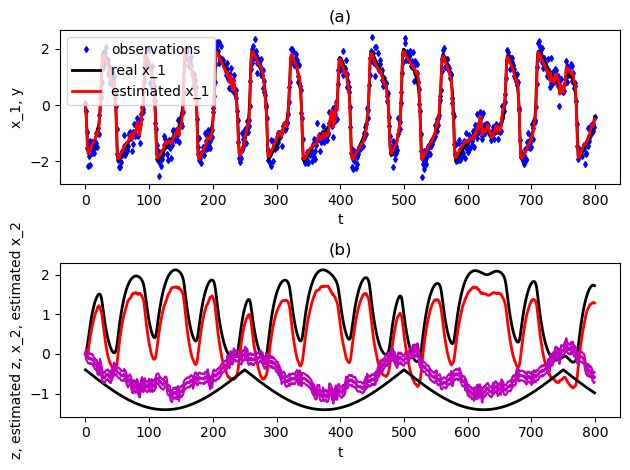

In [16]:

plt.figure()

plt.subplot(2, 1, 1)
plt.plot(y.ravel(), 'bd', markeredgecolor='blue', markerfacecolor='blue', markersize=3)
plt.plot(x[dq + 0, :], color='black', linewidth=2)
plt.plot(xhat[dq + 0, :], 'r', linewidth=2)
plt.xlabel('t')
plt.ylabel('x_1, y')
plt.title('(a)')
plt.legend(('observations', 'real x_1', 'estimated x_1'))
plt.subplot(2, 1, 2)
plt.plot(x[dq + 1, :], color='black', linewidth=2)
plt.plot(xhat[dq + 1, :], 'r', linewidth=2)
plt.plot(x[0, :], color='black', linewidth=2)
for i in range(dq):
    plt.plot(xhat[i, :], 'm', linewidth=2)
for i in range(dq):
    plt.plot(xhat[i, :] + errors[i, :], 'm')
for i in range(dq):
    plt.plot(xhat[i, :] - errors[i, :], 'm')
    
plt.xlabel('t')
plt.ylabel('z, estimated z, x_2, estimated x_2')
plt.title('(b)')


plt.tight_layout()
plt.show()

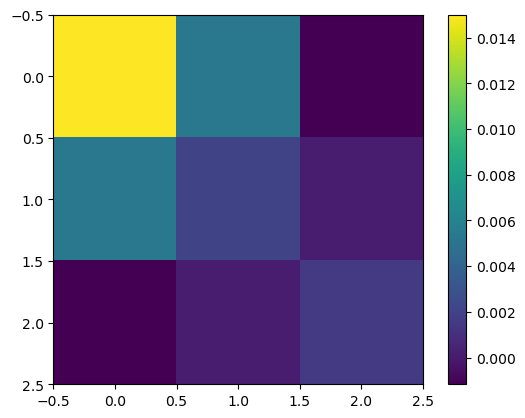

In [27]:
plt.imshow(Pxx[:,:,500])
plt.colorbar()

In [ ]:
params = {'a_mod': 0.8, 'b_mod': 0.3, 'c_mod':3, 'Q': 0.015}

run_UKF(params)